# Research Updates 
**Feb 15, 2023**

### Topics:
1. **HCR Analysis Updates**
2. **High-throughout pec fin morphology assay**

# HCR Analysis

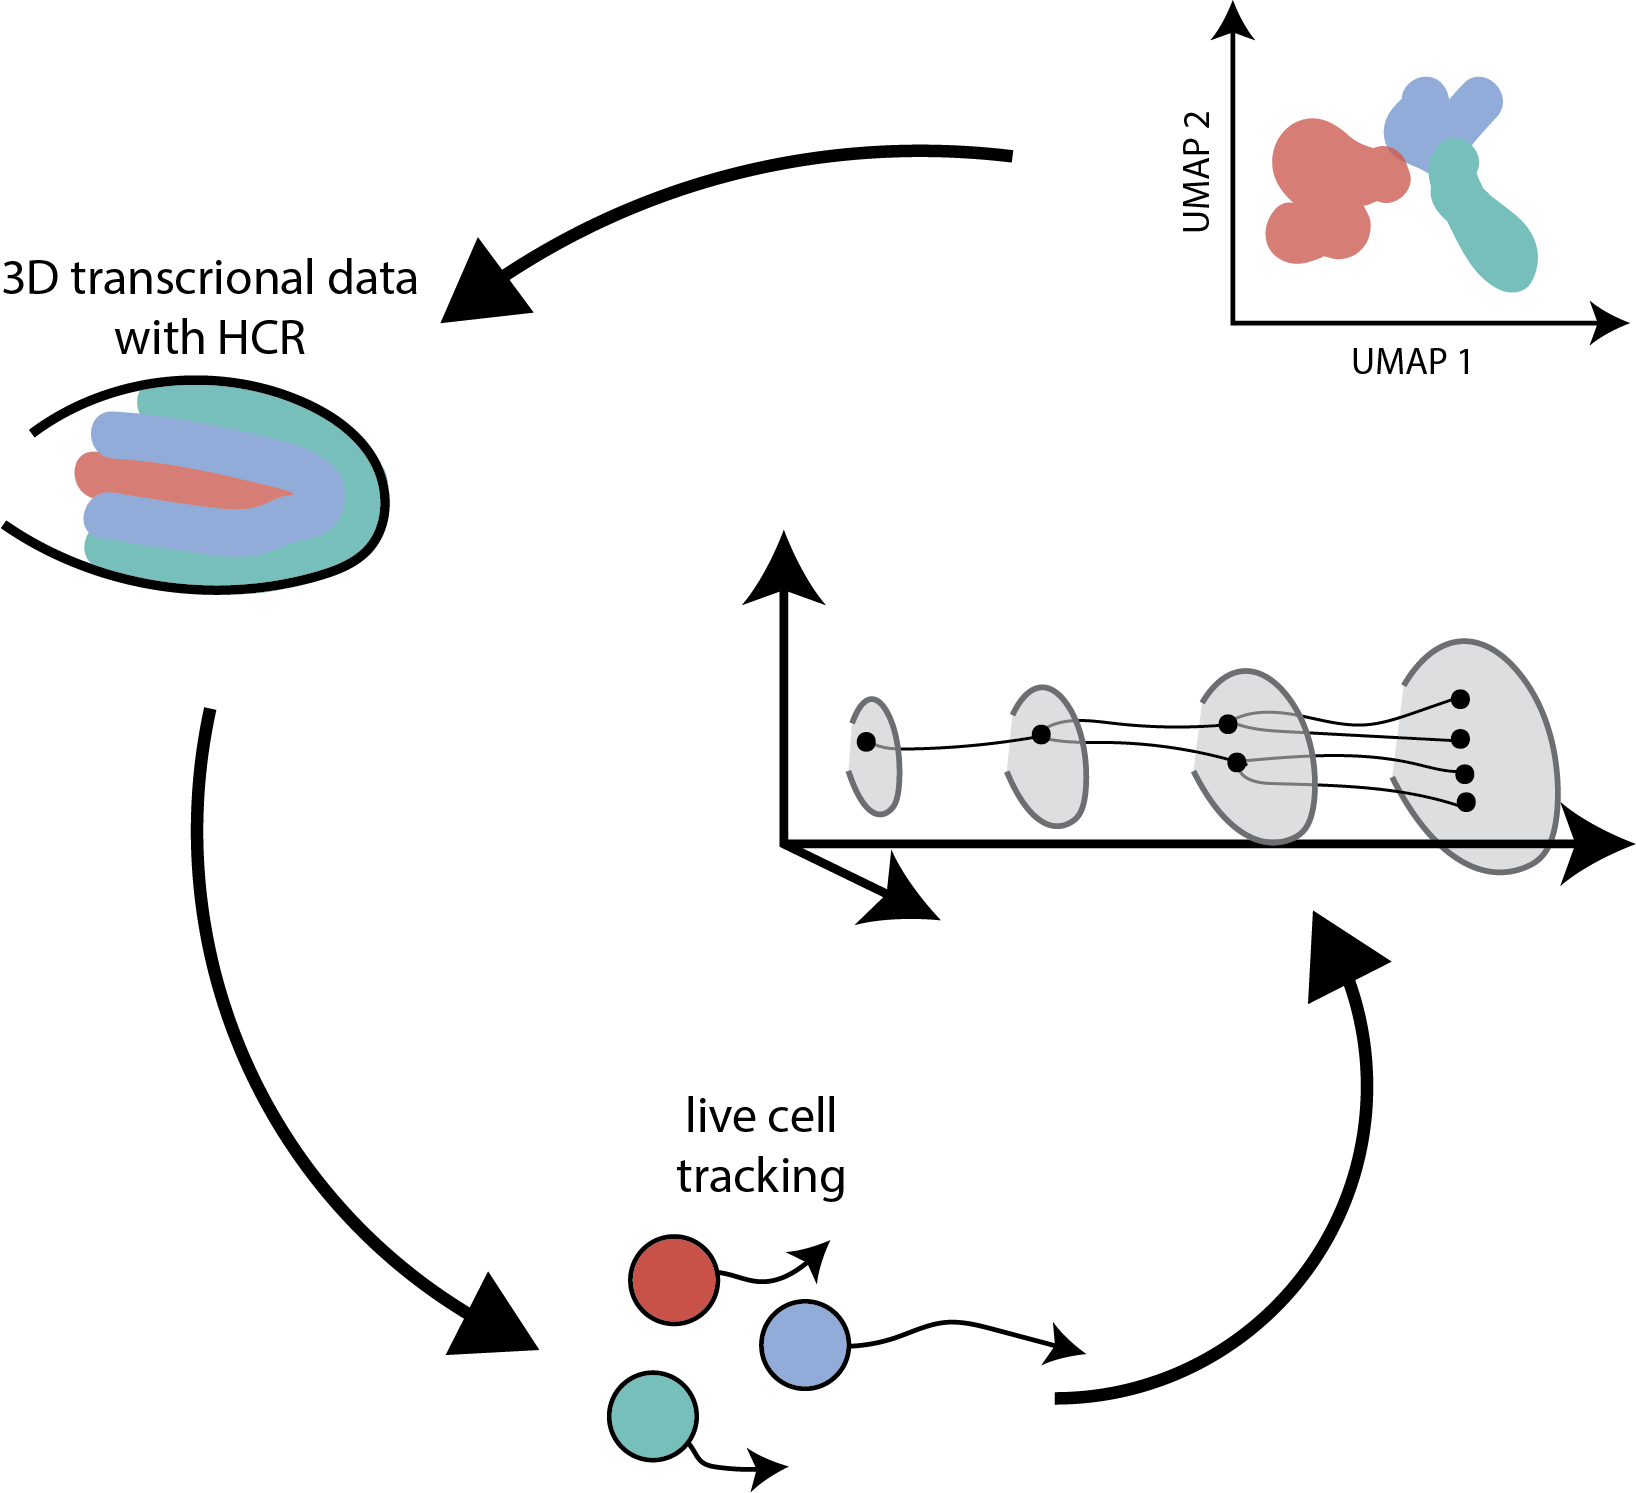

**Overall Objective:** Combine multiple imaging datasets with distinct mRNA markers to generate a quantitative 3D "reference fin"

**Steps:**
1. Nucleus segmentation (done)
2. Pec fin segmentation (done)
3. mRNA quantification (done)
4. Axis inference (in progress)
5. Cross-dataset registration (tbd)

### 1. Nucleus Segmentation

In [1]:
%%capture
# import packages
import numpy as np
import pandas as pd
import napari
import plotly.express as px
import plotly.graph_objects as go
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

# specify name of file to use for testing
filename = "2022_12_15 HCR Hand2 Tbx5a Fgf10a_1"

# load image and label datasets
level = 1
readPath = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/pecFin/HCR_Data/built_zarr_files/" + filename + ".zarr"
readPathLabels = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/pecFin/HCR_Data/built_zarr_files/" + filename + ".zarrlabels"

#############
# Main image
#############

# read the image data
store = parse_url(readPath, mode="r").store
reader = Reader(parse_url(readPath))

# nodes may include images, labels etc
nodes = list(reader())

# first node will be the image pixel data
image_node = nodes[0]
image_data = image_node.data

#############
# Labels
#############

# read the image data
store_lb = parse_url(readPathLabels, mode="r").store
reader_lb = Reader(parse_url(readPathLabels))

# nodes may include images, labels etc
nodes_lb = list(reader_lb())

# first node will be the image pixel data
label_node = nodes_lb[1]
label_data = label_node.data

# extract key image attributes
omero_attrs = image_node.root.zarr.root_attrs['omero']
channel_metadata = omero_attrs['channels']  # list of channels and relevant info
multiscale_attrs = image_node.root.zarr.root_attrs['multiscales']
axis_names = multiscale_attrs[0]['axes']
dataset_info = multiscale_attrs[0]['datasets']  # list containing scale factors for each axis



In [14]:
scale_vec = multiscale_attrs[0]["datasets"][level]["coordinateTransformations"][0]["scale"]
channel_names = [channel_metadata[i]["label"] for i in range(len(channel_metadata))]
colormaps = [channel_metadata[i]["color"] for i in range(len(channel_metadata))]
im_3 = np.asarray(image_data[level])
res_upper = np.percentile(im_3[3, :, :, :], 99.999)
# call napari viewer
viewer = napari.view_image(image_data[level], channel_axis=0, name=channel_names, colormap=colormaps, contrast_limits=[0, res_upper], scale=scale_vec)
labels_layer = viewer.add_labels(label_data[level], name='segmentation', scale=scale_vec)

### 2. Pec fin segmentation

In [9]:
# Load test dataset of nucleus centroids
nc_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/pecFin/HCR_Data/built_zarr_files/" + filename + "_nucleus_props.csv"
nucleus_df = pd.read_csv(nc_path, index_col=0)

nucleus_df["r_scale"] = np.sqrt(nucleus_df["X"]**2 + nucleus_df["Y"]**2 + nucleus_df["Z"]**2)

# clean up data frame
colnames = nucleus_df.columns
clean_indices = [i for i,item in enumerate(colnames) if "Unnamed" not in item]
nucleus_df = nucleus_df.iloc[:, clean_indices]

title_string="All nucleus centroids from: " + filename
fig = px.scatter_3d(nucleus_df, x="X", y="Y", z="Z", 
                opacity=0.5,color="r_scale", color_continuous_scale="ice",
                   title=title_string)

fig.update_traces(marker=dict(size=5))

fig.show()

#### Add pec fin info

In [4]:
# get list of nuclei that are marked as being in pec fin
pec_fin_flag = nucleus_df["pec_fin_flag"]
fin_indices = np.where(pec_fin_flag==1)
not_fin_indices = np.where(pec_fin_flag==0)



# plot
title_string="All nucleus centroids from: " + filename + "(with segmented pec fin)"

fig = px.scatter_3d(nucleus_df.iloc[fin_indices], x="X", y="Y", z="Z", 
                   opacity=0.75,
                   title=title_string,
                   color="r_scale", color_continuous_scale="magenta"                   
                   )

fig.update_traces(marker=dict(size=5))

fig.add_trace(go.Scatter3d(x=nucleus_df["X"].iloc[not_fin_indices], 
                           y=nucleus_df["Y"].iloc[not_fin_indices],
                           z=nucleus_df["Z"].iloc[not_fin_indices], 
                           mode='markers', 
                           opacity=0.3,
                           marker=dict(color="gray",
                             size=5)
                            ))

fig.show()

## 3. Quantify mRNA levels

In [ ]:
from skimage.measure import label, regionprops, regionprops_table

# initialize empty columns
channel_names = [channel_metadata[i]["label"] for i in range(len(channel_metadata))]
for ch in channel_names:
    nucleus_df[ch] = np.nan
    nucleus_df[ch + "_mean"] = np.nan

scale_vec = multiscale_attrs[0]["datasets"][level]["coordinateTransformations"][0]["scale"]

label_array = label_data[level].compute()
image_array = image_data[level]

regions = regionprops(label_array)

# For each region, extract centroid info and integrate mRNA levels
colormaps = [channel_metadata[i]["color"] for i in range(len(channel_metadata))]
         
# compute each channel of image array separately to avoid dask error
im_array_list = []
for ch in range(len(channel_names)-1):
    im_array_list.append(np.asarray(image_array[ch, :, :, :].compute()))
    
# iterate through regions to extract key info
for rgi, rg in enumerate(regions):
    # get coordinates
    nucleus_df[["Z", "Y", "X"]].iloc[rgi] = np.multiply(rg.centroid, scale_vec)
    
    # iterate through channels
    nc_coords = rg.coords.astype(int)
    n_pix = nc_coords.shape[0]
    for ch in range(3):
        #nc_ch_coords = np.concatenate((np.ones((n_pix,1))*ch, nc_coords), axis=1).astype(int)
        im_ch = im_array_list[ch]
        mRNA_integral = np.sum(im_ch[tuple(nc_coords.T)])
        
        nucleus_df[channel_names[ch]].iloc[rgi] = mRNA_integral
        nucleus_df[channel_names[ch] + "_mean"].iloc[rgi] = mRNA_integral / n_pix
        


### Make scatter plots showing mRNA levels for each gene

In [6]:
import plotly.graph_objects as go

# normalize
for ch in range(3):
    nucleus_df[channel_names[ch]] = nucleus_df[channel_names[ch]] / np.max(nucleus_df[channel_names[ch]])
    nucleus_df[channel_names[ch] + "_mean"] = nucleus_df[channel_names[ch]+ "_mean"] / np.max(nucleus_df[channel_names[ch] + "_mean"])
    
fin_nuclei = np.where(nucleus_df["pec_fin_flag"]==1)

colormaps[0] = "deep"
colormaps[1] = "viridis"
colormaps[2] = "ice"
                      
channel_ind = 0
mRNA_channel = channel_names[channel_ind] + "_mean"

# estimate background
nucleus_df_fin = nucleus_df.iloc[fin_nuclei]

# fig = px.histogram(nucleus_df_fin, x=mRNA_channel)
# fig.show()
fig = px.scatter_3d(nucleus_df_fin, x="X", y="Y", z="Z", 
              opacity=0.5, color=mRNA_channel, 
              color_continuous_scale=colormaps[channel_ind],
              template="plotly",
              title= "Nuclear mRNA lavels for: " + channel_names[channel_ind])

fig.update_traces(marker=dict(size=6))
                
fig.show()


### Question:
Is it worth calibrating mRNA levels in terms of absolute mRNA counts?

### Next steps:
1. Infer P-D, A-P, and D-V axes for each dataset
2. Use inferred axes as a basis for mapping each set to a shared "reference" space
3. Use this to:
    1. Identify 3D location of cell types from sci data
    2. Infer likely cell-cell interactions based on spatial proximity

# High-throughput pec fin morphology assay

### 1. I've identified a microscope that is capable of capturing high-throughput 3D images from 96 well plates

In [15]:
from aicsimageio import AICSImage

full_filename = "/Volumes/LaCie/YX1/20230112/RNA100_GFP_4x_wholeEmbryo_highResZ.nd2"

imObject = AICSImage(full_filename)
imData = imObject.data
# Extract pixel sizes and bit_depth
res_raw = imObject.physical_pixel_sizes
res_array = np.asarray(res_raw)

full_viewer = napari.view_image(imData, colormap="green", scale=res_array)


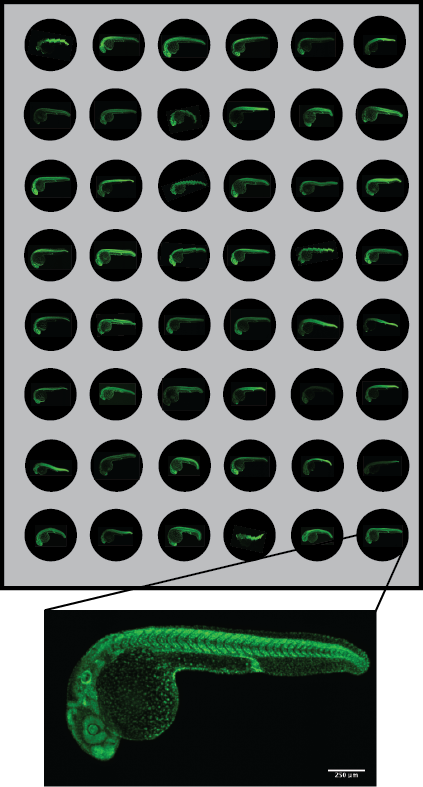

In [12]:
fin_filename = "/Volumes/LaCie/YX1/20230112/RNA300_GFP_20x_pecFin_noBackgroundLight.nd2"

imObjectFin = AICSImage(fin_filename)
imDataFin = imObjectFin.data
# Extract pixel sizes and bit_depth
res_raw_fin = imObjectFin.physical_pixel_sizes
res_array_fin = np.asarray(res_raw_fin)

fin_viewer = napari.view_image(imDataFin, colormap="green", scale=res_array_fin)

**I can